In [102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import pandas as pd
from scipy import signal

### Loading the data into NumPy arrays

In [69]:
traindf = pd.read_csv('../data/train.csv', header = None)
valdf = pd.read_csv('../data/val.csv', header = None)
testdf = pd.read_csv('../data/test.csv', header = None)
def return_segments(df):
    ''' Returns 2 arrays : 
        x of shape (num_examples, num_features = 150)
        y of shape (num_examples, num_classes = 5)
        Extracts this from given Pandas DataFrame
    '''
    x = np.zeros((len(df) // 150, 450))
    y = np.zeros((len(df) // 150, 5))
    for i in range(1, len(df) // 150) : 
        # taking 150 values of 3 channels at a time, flattening and 
        temp = df.iloc[(i - 1) * 150 : i * 150,  : 3].values
        x[i - 1] = np.transpose(temp).reshape(450)
        # finding single one_hot encoded label (which occurs maximum times in 150 values)
        label_array = df.iloc[((i - 1) * 150) : i * 150, 3 : ].values
        ind = np.argmax(np.sum(label_array, axis = 0))
        label = np.zeros_like(df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        y[i - 1] = label
        
    num = len(df) // 150
    # last example isn't considered in the loop
    temp = df.iloc[(num - 1) * 150 : , : 3].values
    x[num - 1] = np.transpose(temp).reshape(450)
    # just taking the central value for the last label
    y[num - 1] = df.iloc[((num - 1) * 150) + 75, 3 : ].values
    return x, y

# Calling loading function and load all data into NumPy arrays
# as required by sklearn
x_test, y_test_ = return_segments(testdf)
x_train, y_train_ = return_segments(traindf)
# Converting one_hot encoded labels to integers
y_test = np.argmax(y_test_, axis = 1)
y_train = np.argmax(y_train_, axis = 1)

### Using a low pass filter

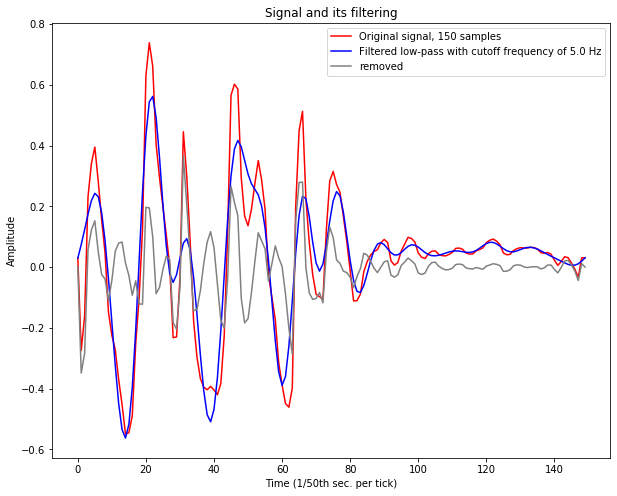

In [214]:
# Source : https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
def butter_lowpass(cutoff, nyq_freq, order = 4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Filter signal x, result stored to y
cutoff_frequency = 5.0
x = x_train[153, 300 : 450]
y = butter_lowpass_filter(x, cutoff_frequency, sample_rate / 2)
signal_length = len(x)
# Difference acts as a special high-pass from a reversed butterworth filter. 
diff = np.array(x) - np.array(y)
# Visualize
plt.figure(figsize=(10, 8))
plt.plot(x, color='red', label="Original signal, {} samples".format(signal_length))
plt.plot(y, color='blue', label="Filtered low-pass with cutoff frequency of {} Hz".format(cutoff_frequency))
plt.plot(diff, color='gray', label="removed")
plt.title("Signal and its filtering")
plt.xlabel('Time (1/50th sec. per tick)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Checking the FFT of filtered and original signal

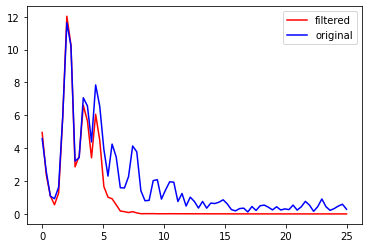

In [215]:
# Number of sample points
N = 150
# Sample Spacing (ideally it is 50 Hz and we shall consider that itself)
T = 1 / 50

# FFT of filtered output
yf = scipy.fftpack.fft(y)
# FFT of input
yf_ = scipy.fftpack.fft(x)
xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)

fig, ax = plt.subplots()
ax.plot(xf, np.abs(yf[ : N // 2]), 'r', label = 'filtered')
ax.plot(xf, np.abs(yf_[ : N // 2]), 'b', label = 'original')
plt.legend()
plt.show()

### Alternative way of computing and plotting FFT
This way is a bit cleaner, so need to choose between this (`numpy.fft.fft`) and above method (`scipy.fftpack.fft`) later. (LOW-PRIORITY)

Text(0, 0.5, '|Y(freq)|')

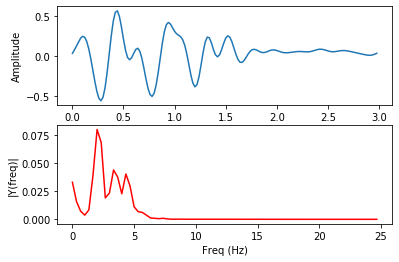

In [219]:
Fs = 50.0;  # sampling rate
Ts = 1.0 / Fs; # sampling interval
t = np.arange(0, 3, Ts) # time vector

# Uncomment below line to see FFT of original signal
# y = x
n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n//2)]

fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq, abs(Y), 'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')